In [1]:
import numpy as np
import gzip
import pickle
import sys
import copy
import os.path
import pdb
from copy import deepcopy

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

from run_split import SplitMnistGenerator, SplitMnistRandomGenerator, SplitMnistBackgroundGenerator
from alg.cla_models_multihead import IBP_NN, Vanilla_NN
from alg.utils import get_uncertainties, get_scores, concatenate_results
from visualise import plot_uncertainties, plot_Zs
import tensorflow as tf

W1104 11:54:44.079918 140040727455552 deprecation_wrapper.py:119] From alg/cla_models_multihead.py:9: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



# New results Normal MNIST

In [2]:
with open('results/split_mnist_res5_split_2l_sh.pkl', 'rb') as input_file:
    d = pickle.load(input_file)
d.keys()

dict_keys(['vcl_ibp', 'vcl_h10', 'vcl_h5', 'vcl_h50', 'uncerts_ibp', 'uncerts_vcl_h5', 'uncerts_vcl_h10', 'uncerts_vcl_h50', 'Z'])

In [3]:
ibp_acc = d['vcl_ibp'] # 5, 5, 5
vcl_result = d['vcl_h10']
vcl_result_h5 = d['vcl_h5']
vcl_result_h50 = d['vcl_h50']
_ibp_acc = np.mean(ibp_acc, 0)
_vcl_result = np.mean(vcl_result, 0)
_vcl_result_h5 = np.mean(vcl_result_h5, 0)
_vcl_result_h50 = np.mean(vcl_result_h50, 0)
__ibp_acc = np.nanmean(ibp_acc, (0,1))
__vcl_result = np.nanmean(vcl_result, (0,1))
__vcl_result_h5 = np.nanmean(vcl_result_h5, (0,1))
__vcl_result_h50 = np.nanmean(vcl_result_h50, (0,1))

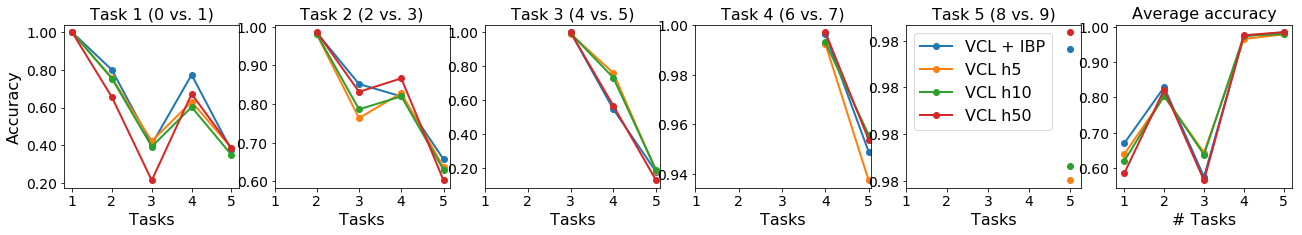

In [4]:
from matplotlib.ticker import FormatStrFormatter
lw = 2
grid_color = '0.1'
grid_lw = 0.2
title_size = 16
label_size = 22
tick_size = 14
legend_size = 16

titles = {0: "Task 1 (0 vs. 1)",
          1: "Task 2 (2 vs. 3)",
          2: "Task 3 (4 vs. 5)",
          3: "Task 4 (6 vs. 7)",
          4: "Task 5 (8 vs. 9)"}
no_tasks=5
fig, ax = plt.subplots(1, 6, figsize=(22, 3))
for i in range(no_tasks):
    ax[i].plot(np.arange(len(ibp_acc[:, i]))+1, _ibp_acc[:, i], label='VCL + IBP', marker='o', linewidth=lw)
    ax[i].plot(np.arange(len(vcl_result_h5[:, i]))+1, _vcl_result_h5[:, i], label='VCL h5', marker='o', linewidth=lw)
    ax[i].plot(np.arange(len(vcl_result[:, i]))+1, _vcl_result[:, i], label='VCL h10', marker='o', linewidth=lw)
    ax[i].plot(np.arange(len(vcl_result_h50[:, i]))+1, _vcl_result_h50[:, i], label='VCL h50', marker='o', linewidth=lw)
    ax[i].set_title(titles[i], fontsize=legend_size)
    ax[i].set_xticks(range(1, len(vcl_result[:,i])+1))
    ax[i].set_xlabel('Tasks', fontsize=legend_size)
    ax[i].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax[i].tick_params(labelsize=tick_size)
    if i == 4:
        ax[i].legend(fontsize=legend_size)
    if i == 0:
        ax[i].set_ylabel('Accuracy', fontsize=legend_size)
ax[5].plot(np.arange(len(__ibp_acc))+1, __ibp_acc, label='VCL + IBP', marker='o', linewidth=lw)
ax[5].plot(np.arange(len(__vcl_result))+1, __vcl_result_h5, label='VCL h5', marker='o', linewidth=lw)
ax[5].plot(np.arange(len(__vcl_result))+1, __vcl_result, label='VCL h10', marker='o', linewidth=lw)
ax[5].plot(np.arange(len(__vcl_result))+1, __vcl_result_h50, label='VCL h50', marker='o', linewidth=lw)
ax[5].set_xticks(range(1, len(_ibp_acc)+1))
ax[5].set_title('Average accuracy', fontsize=legend_size)
ax[5].set_xlabel('# Tasks', fontsize=legend_size)
ax[5].tick_params(labelsize=tick_size)
ax[5].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
#ax[5].legend()
#plt.savefig("plots/split_normal_all_sh_2l.pdf", bbox_inches='tight')
fig.show()

In [5]:
print("overall ibp acc: {}".format(np.nanmean(ibp_acc)))
print("overall vcl h5: {}".format(np.nanmean(vcl_result_h5)))
print("overall vcl h10: {}".format(np.nanmean(vcl_result)))
print("overall vcl h50: {}".format(np.nanmean(vcl_result_h50)))

overall ibp acc: 0.75438379249313
overall vcl h5: 0.7494861592802725
overall vcl h10: 0.7436558431767056
overall vcl h50: 0.722737995043216


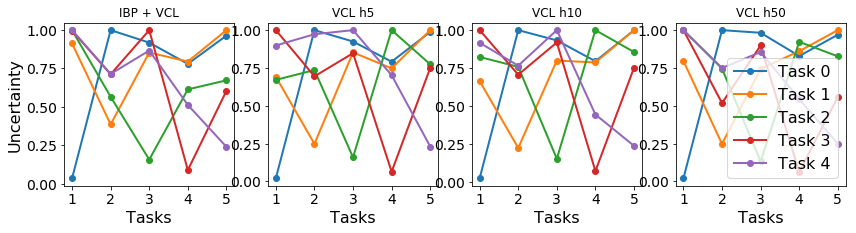

In [6]:
all_ibp_uncerts = d['uncerts_ibp'] # 5, 5, 5
all_vcl_h5_uncerts = d['uncerts_vcl_h5']
all_vcl_h10_uncerts = d['uncerts_vcl_h10']
all_vcl_h50_uncerts = d['uncerts_vcl_h50']
num_tasks=5
tag='split_mnist_sh_2layer'
plot_uncertainties(num_tasks, all_ibp_uncerts, all_vcl_h5_uncerts, all_vcl_h10_uncerts, all_vcl_h50_uncerts, tag)

/nfs/home/samuelk/anaconda2/envs/py36_tf_cpu/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


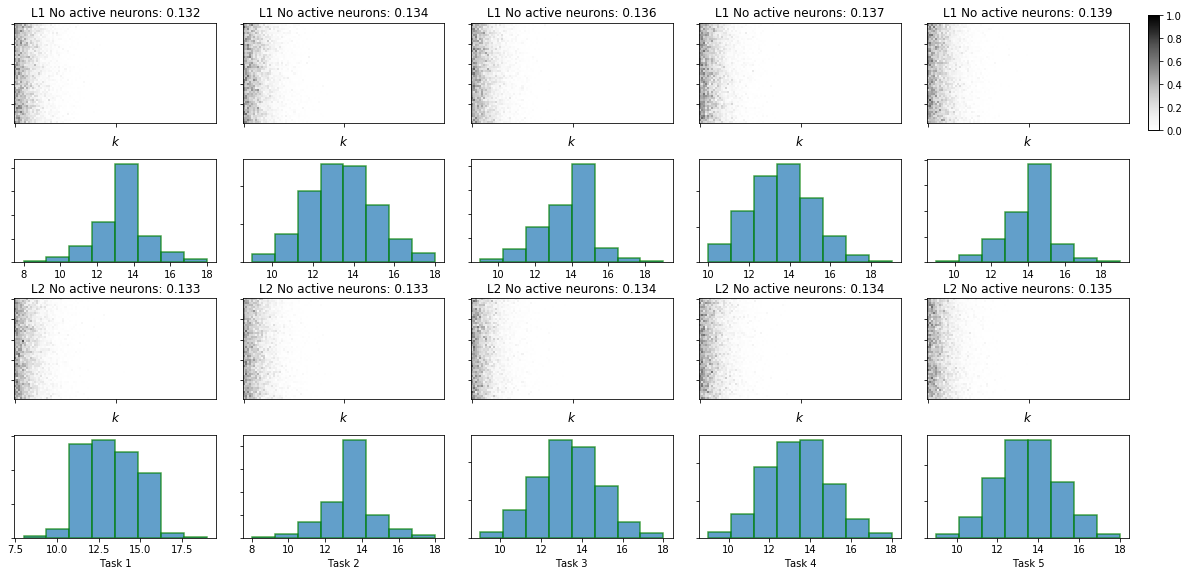

In [7]:
num_layers=2
Zs=d['Z']
dataset='split_vanilla_sh_2l'
plot_Zs(num_tasks, num_layers, Zs[0], dataset, tag)

# Random background noise MNIST

In [8]:
with open('results/split_mnist_res5_split_random_sh_2l.pkl', 'rb') as input_file:
    d = pickle.load(input_file)
d.keys()

dict_keys(['vcl_ibp', 'vcl_h10', 'vcl_h5', 'vcl_h50', 'uncerts_ibp', 'uncerts_vcl_h5', 'uncerts_vcl_h10', 'uncerts_vcl_h50', 'Z'])

In [9]:
ibp_acc = d['vcl_ibp'] # 5, 5, 5
vcl_result = d['vcl_h10']
vcl_result_h5 = d['vcl_h5']
vcl_result_h50 = d['vcl_h50']
_ibp_acc = np.mean(ibp_acc, 0)
_vcl_result = np.mean(vcl_result, 0)
_vcl_result_h5 = np.mean(vcl_result_h5, 0)
_vcl_result_h50 = np.mean(vcl_result_h50, 0)
__ibp_acc = np.nanmean(ibp_acc, (0,1))
__vcl_result = np.nanmean(vcl_result, (0,1))
__vcl_result_h5 = np.nanmean(vcl_result_h5, (0,1))
__vcl_result_h50 = np.nanmean(vcl_result_h50, (0,1))

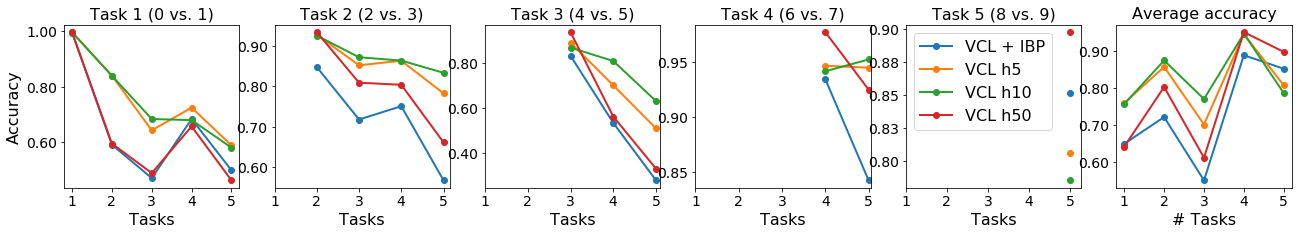

In [10]:
from matplotlib.ticker import FormatStrFormatter
lw = 2
grid_color = '0.1'
grid_lw = 0.2
title_size = 16
label_size = 22
tick_size = 14
legend_size = 16

titles = {0: "Task 1 (0 vs. 1)",
          1: "Task 2 (2 vs. 3)",
          2: "Task 3 (4 vs. 5)",
          3: "Task 4 (6 vs. 7)",
          4: "Task 5 (8 vs. 9)"}
no_tasks=5
fig, ax = plt.subplots(1, 6, figsize=(22, 3))
for i in range(no_tasks):
    ax[i].plot(np.arange(len(ibp_acc[:, i]))+1, _ibp_acc[:, i], label='VCL + IBP', marker='o', linewidth=lw)
    ax[i].plot(np.arange(len(vcl_result_h5[:, i]))+1, _vcl_result_h5[:, i], label='VCL h5', marker='o', linewidth=lw)
    ax[i].plot(np.arange(len(vcl_result[:, i]))+1, _vcl_result[:, i], label='VCL h10', marker='o', linewidth=lw)
    ax[i].plot(np.arange(len(vcl_result_h50[:, i]))+1, _vcl_result_h50[:, i], label='VCL h50', marker='o', linewidth=lw)
    ax[i].set_title(titles[i], fontsize=legend_size)
    ax[i].set_xticks(range(1, len(vcl_result[:,i])+1))
    ax[i].set_xlabel('Tasks', fontsize=legend_size)
    ax[i].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax[i].tick_params(labelsize=tick_size)
    if i == 4:
        ax[i].legend(fontsize=legend_size)
    if i == 0:
        ax[i].set_ylabel('Accuracy', fontsize=legend_size)
ax[5].plot(np.arange(len(__ibp_acc))+1, __ibp_acc, label='VCL + IBP', marker='o', linewidth=lw)
ax[5].plot(np.arange(len(__vcl_result))+1, __vcl_result_h5, label='VCL h5', marker='o', linewidth=lw)
ax[5].plot(np.arange(len(__vcl_result))+1, __vcl_result, label='VCL h10', marker='o', linewidth=lw)
ax[5].plot(np.arange(len(__vcl_result))+1, __vcl_result_h50, label='VCL h50', marker='o', linewidth=lw)
ax[5].set_xticks(range(1, len(_ibp_acc)+1))
ax[5].set_title('Average accuracy', fontsize=legend_size)
ax[5].set_xlabel('# Tasks', fontsize=legend_size)
ax[5].tick_params(labelsize=tick_size)
ax[5].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
#ax[5].legend()
plt.savefig("plots/split_rand_all_sh_2l.pdf", bbox_inches='tight')
fig.show()

In [11]:
print("overall ibp acc: {}".format(np.nanmean(ibp_acc)))
print("overall vcl h5: {}".format(np.nanmean(vcl_result_h5)))
print("overall vcl h10: {}".format(np.nanmean(vcl_result)))
print("overall vcl h50: {}".format(np.nanmean(vcl_result_h50)))

overall ibp acc: 0.693214625012179
overall vcl h5: 0.8012597567686561
overall vcl h10: 0.8176274966310222
overall vcl h50: 0.7360614417744404


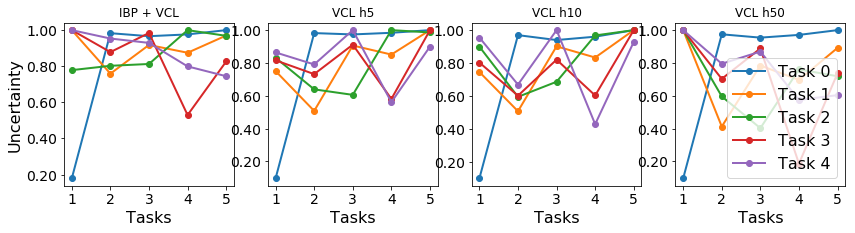

In [12]:
all_ibp_uncerts = d['uncerts_ibp'] # 5, 5, 5
all_vcl_h5_uncerts = d['uncerts_vcl_h5']
all_vcl_h10_uncerts = d['uncerts_vcl_h10']
all_vcl_h50_uncerts = d['uncerts_vcl_h50']
num_tasks=5
tag='split_mnist_random_sh_2layer'
plot_uncertainties(num_tasks, all_ibp_uncerts, all_vcl_h5_uncerts, all_vcl_h10_uncerts, all_vcl_h50_uncerts, tag)

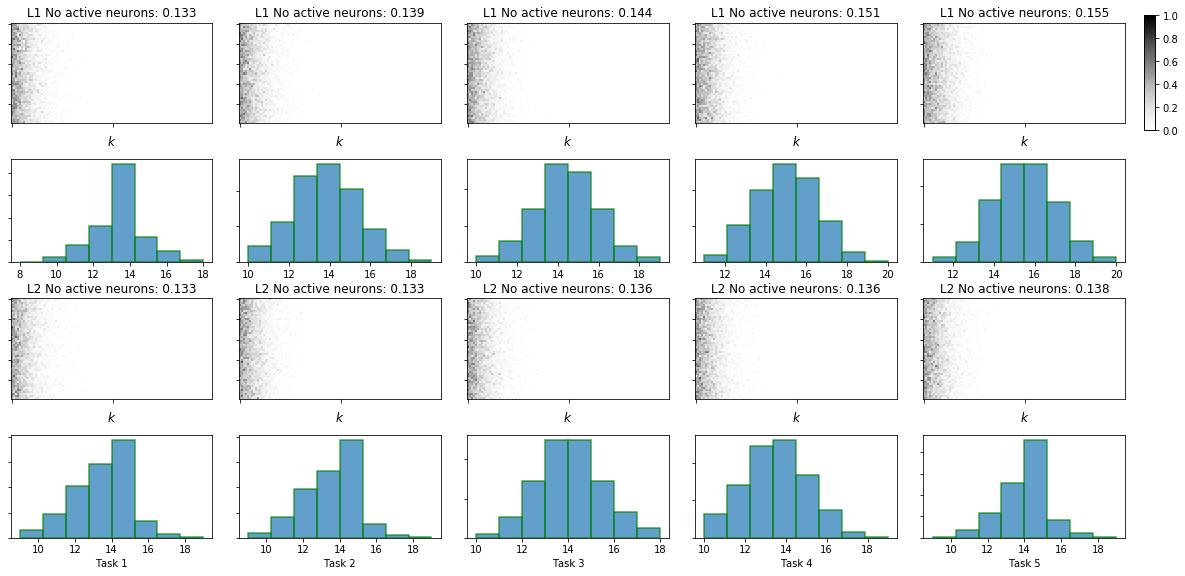

In [13]:
num_layers=2
Zs=d['Z']
dataset='split_random_sh_2l'
plot_Zs(num_tasks, num_layers, Zs[0], dataset, tag)

# Image background MNIST

In [14]:
#split_mnist_res5_split_background.pkl
with open('results/split_mnist_res5_split_background_sh_2l.pkl', 'rb') as input_file:
    d = pickle.load(input_file)
d.keys()

dict_keys(['vcl_ibp', 'vcl_h10', 'vcl_h5', 'vcl_h50', 'uncerts_ibp', 'uncerts_vcl_h5', 'uncerts_vcl_h10', 'uncerts_vcl_h50', 'Z'])

In [15]:
ibp_acc = d['vcl_ibp'] # 5, 5, 5
vcl_result = d['vcl_h10']
vcl_result_h5 = d['vcl_h5']
vcl_result_h50 = d['vcl_h50']
_ibp_acc = np.mean(ibp_acc, 0)
_vcl_result = np.mean(vcl_result, 0)
_vcl_result_h5 = np.mean(vcl_result_h5, 0)
_vcl_result_h50 = np.mean(vcl_result_h50, 0)
__ibp_acc = np.nanmean(ibp_acc, (0,1))
__vcl_result = np.nanmean(vcl_result, (0,1))
__vcl_result_h5 = np.nanmean(vcl_result_h5, (0,1))
__vcl_result_h50 = np.nanmean(vcl_result_h50, (0,1))

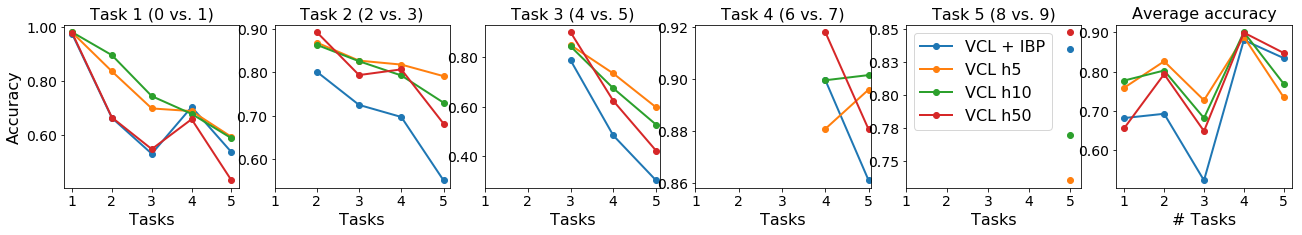

In [16]:
from matplotlib.ticker import FormatStrFormatter
lw = 2
grid_color = '0.1'
grid_lw = 0.2
title_size = 16
label_size = 22
tick_size = 14
legend_size = 16

titles = {0: "Task 1 (0 vs. 1)",
          1: "Task 2 (2 vs. 3)",
          2: "Task 3 (4 vs. 5)",
          3: "Task 4 (6 vs. 7)",
          4: "Task 5 (8 vs. 9)"}
no_tasks=5
fig, ax = plt.subplots(1, 6, figsize=(22, 3))
for i in range(no_tasks):
    ax[i].plot(np.arange(len(ibp_acc[:, i]))+1, _ibp_acc[:, i], label='VCL + IBP', marker='o', linewidth=lw)
    ax[i].plot(np.arange(len(vcl_result_h5[:, i]))+1, _vcl_result_h5[:, i], label='VCL h5', marker='o', linewidth=lw)
    ax[i].plot(np.arange(len(vcl_result[:, i]))+1, _vcl_result[:, i], label='VCL h10', marker='o', linewidth=lw)
    ax[i].plot(np.arange(len(vcl_result_h50[:, i]))+1, _vcl_result_h50[:, i], label='VCL h50', marker='o', linewidth=lw)
    ax[i].set_title(titles[i], fontsize=legend_size)
    ax[i].set_xticks(range(1, len(vcl_result[:,i])+1))
    ax[i].set_xlabel('Tasks', fontsize=legend_size)
    ax[i].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax[i].tick_params(labelsize=tick_size)
    if i == 4:
        ax[i].legend(fontsize=legend_size)
    if i == 0:
        ax[i].set_ylabel('Accuracy', fontsize=legend_size)
ax[5].plot(np.arange(len(__ibp_acc))+1, __ibp_acc, label='VCL + IBP', marker='o', linewidth=lw)
ax[5].plot(np.arange(len(__vcl_result))+1, __vcl_result_h5, label='VCL h5', marker='o', linewidth=lw)
ax[5].plot(np.arange(len(__vcl_result))+1, __vcl_result, label='VCL h10', marker='o', linewidth=lw)
ax[5].plot(np.arange(len(__vcl_result))+1, __vcl_result_h50, label='VCL h50', marker='o', linewidth=lw)
ax[5].set_xticks(range(1, len(_ibp_acc)+1))
ax[5].set_title('Average accuracy', fontsize=legend_size)
ax[5].set_xlabel('# Tasks', fontsize=legend_size)
ax[5].tick_params(labelsize=tick_size)
ax[5].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
#ax[5].legend()
plt.savefig("plots/split_background_all_sh_2l.pdf", bbox_inches='tight')
fig.show()

In [17]:
print("overall ibp acc: {}".format(np.nanmean(ibp_acc)))
print("overall vcl h5: {}".format(np.nanmean(vcl_result_h5)))
print("overall vcl h10: {}".format(np.nanmean(vcl_result)))
print("overall vcl h50: {}".format(np.nanmean(vcl_result_h50)))

overall ibp acc: 0.6901357211248412
overall vcl h5: 0.7864939730675897
overall vcl h10: 0.7811930751978775
overall vcl h50: 0.736907314074678


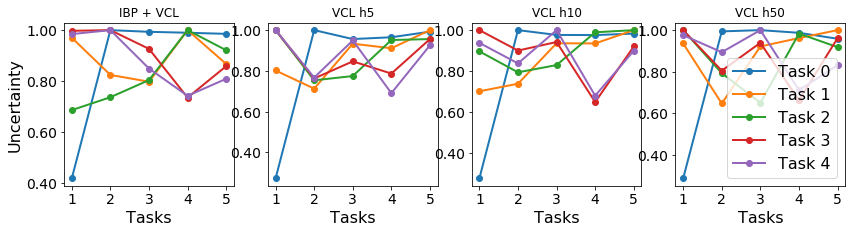

In [18]:
all_ibp_uncerts = d['uncerts_ibp'] # 5, 5, 5
all_vcl_h5_uncerts = d['uncerts_vcl_h5']
all_vcl_h10_uncerts = d['uncerts_vcl_h10']
all_vcl_h50_uncerts = d['uncerts_vcl_h50']
num_tasks=5
tag='split_mnist_background_sh_2layer'
plot_uncertainties(num_tasks, all_ibp_uncerts, all_vcl_h5_uncerts, all_vcl_h10_uncerts, all_vcl_h50_uncerts, tag)

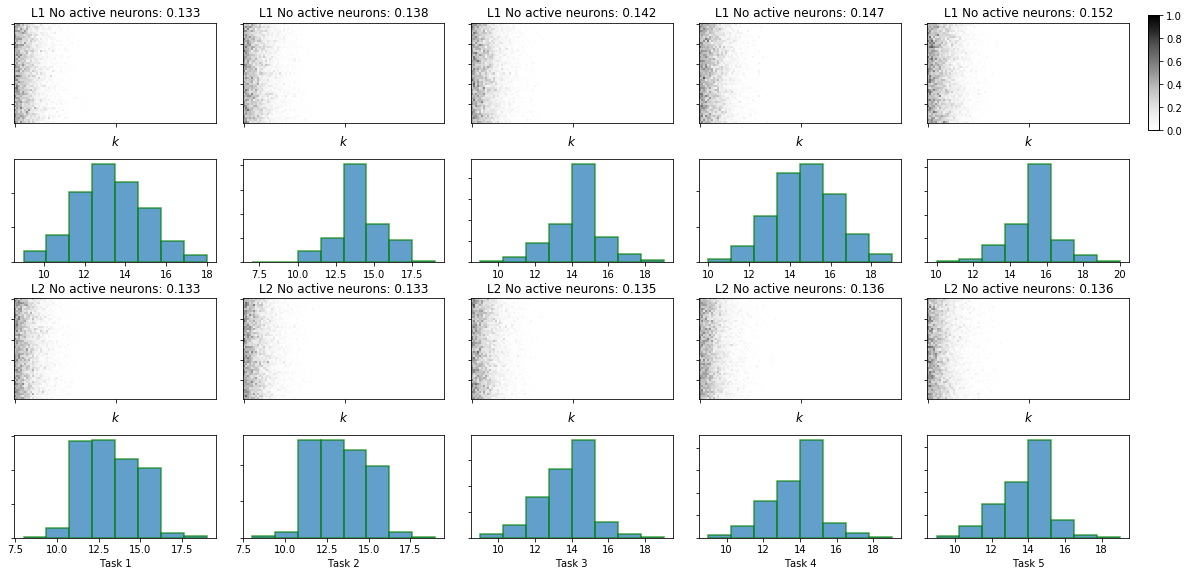

In [19]:
num_layers=2
Zs=d['Z']
dataset='split_background_sh_2l'
plot_Zs(num_tasks, num_layers, Zs[0], dataset, tag)